# train.ipynb: 用所有的训练集训练决策树
这里需要用到预处理过的数据，以减少代码运算时间。请先跑`waveform.py`。

In [1]:
import os
import multiprocessing
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.stats import kstat
from sklearn.linear_model import LinearRegression 
%matplotlib inline
from utils import loadData, getNum, getPePerWF, saveData, lossfunc_train, lossfunc_eval
from tqdm import tqdm # 展示进度条
import lightgbm as lgb # 训练决策树使用的包

`waveform.py`预处理后的数据在./train中，文件名格式为`f"final_{i}_wf.h5"`

In [2]:
trainPathRoot = './data/final-'
processedPathRoot = './train/final_'

从预处理的数据中，读取训练两个训练集需要的原始数据，并将18个训练集的数据拼接起来。
1. `intTrainWF`: 波形积分
2. `pointsPerTrainWF`: 超过阈值的点数
3. `pePerTrainWFCalc`: 每个波形对应的PE数计算值
4. `meanPeTimePerTrainWF`: 每个波形对应的PETime的手算平均值
5. `pePerTrainWF`: 每个波形对应的PE数真值
6. `wfIndices`: (n+1,)的ndarray，下标为i表示EventID=i的第一次出现在Waveform表中的下标，下标为n表示Waveform表长度

In [3]:
intTrainWF = np.array([], dtype='<i4') # 读取波形积分
pointsPerTrainWF = np.array([], dtype='<i2') # 读取超过阈值的点数
pePerTrainWFCalc = np.array([], dtype='<i2') # 读取每个波形对应的PE数计算值
meanPeTimePerTrainWF = np.array([], dtype='<f8') # 读取每个波形对应的PETime的手算平均值
pePerTrainWF = np.array([], dtype='<i2') # 读取每个波形对应的PE数真值

wfIndices = np.array([0], dtype=int)
p = np.array([], dtype='<f8')

previousIndex = 0
for i in tqdm(range(2, 20)):
    with h5py.File(f"{processedPathRoot}{i}_wf.h5", 'r') as ipt:
        intTrainWF = np.append(intTrainWF, ipt['Waveform']['intWF'][...])
        pointsPerTrainWF = np.append(pointsPerTrainWF, ipt['Waveform']['pointsPerWF'][...])
        pePerTrainWFCalc = np.append(pePerTrainWFCalc, ipt['Waveform']['pePerWFCalc'][...])
        meanPeTimePerTrainWF = np.append(meanPeTimePerTrainWF, ipt['Waveform']['meanPeTimePerWF'][...])
        pePerTrainWF = np.append(pePerTrainWF, ipt['Waveform']['pePerWF'][...])
        
        wfIndicesChunk = ipt['WfIndices'][...]
        trainPT = loadData(f"./data/final-{i}.h5", 'p')
        
        wfIndices = np.append(wfIndices, np.zeros(trainPT.shape[0]))
        p = np.append(p, np.zeros(trainPT.shape[0]))
        finalIndex = previousIndex + trainPT.shape[0] + 1
        wfIndices[previousIndex:finalIndex] = wfIndicesChunk + wfIndices[previousIndex]
        p[previousIndex:(finalIndex-1)] = trainPT['p']
        previousIndex = finalIndex-1

  6%|▌         | 1/18 [00:00<00:06,  2.82it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9137011,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6041164,), type "|V2008"> Waveform /Waveform


 11%|█         | 2/18 [00:00<00:06,  2.56it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9222643,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6021458,), type "|V2008"> Waveform /Waveform


 17%|█▋        | 3/18 [00:01<00:06,  2.44it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9009875,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (5987414,), type "|V2008"> Waveform /Waveform


 22%|██▏       | 4/18 [00:01<00:05,  2.34it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9147704,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6004696,), type "|V2008"> Waveform /Waveform


 28%|██▊       | 5/18 [00:02<00:05,  2.18it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9262473,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6115519,), type "|V2008"> Waveform /Waveform


 33%|███▎      | 6/18 [00:02<00:05,  2.03it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9216927,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6075119,), type "|V2008"> Waveform /Waveform


 39%|███▉      | 7/18 [00:03<00:05,  1.91it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9103034,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (5990370,), type "|V2008"> Waveform /Waveform


 44%|████▍     | 8/18 [00:03<00:05,  1.80it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9139087,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (5965634,), type "|V2008"> Waveform /Waveform


 50%|█████     | 9/18 [00:04<00:05,  1.70it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9067611,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (1999,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (5965655,), type "|V2008"> Waveform /Waveform


 56%|█████▌    | 10/18 [00:05<00:04,  1.60it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9219415,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6039820,), type "|V2008"> Waveform /Waveform


 61%|██████    | 11/18 [00:06<00:04,  1.51it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9141287,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (5995751,), type "|V2008"> Waveform /Waveform


 67%|██████▋   | 12/18 [00:06<00:04,  1.43it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9157071,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (5984516,), type "|V2008"> Waveform /Waveform


 72%|███████▏  | 13/18 [00:07<00:03,  1.35it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9191741,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (1998,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6020168,), type "|V2008"> Waveform /Waveform


 78%|███████▊  | 14/18 [00:08<00:03,  1.29it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9143911,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6038985,), type "|V2008"> Waveform /Waveform


 83%|████████▎ | 15/18 [00:09<00:02,  1.23it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9219236,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (1999,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6039233,), type "|V2008"> Waveform /Waveform


 89%|████████▉ | 16/18 [00:10<00:01,  1.17it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9104863,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (5981409,), type "|V2008"> Waveform /Waveform


 94%|█████████▍| 17/18 [00:11<00:00,  1.12it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9202609,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6058586,), type "|V2008"> Waveform /Waveform


100%|██████████| 18/18 [00:12<00:00,  1.46it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9261569,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6085040,), type "|V2008"> Waveform /Waveform


下面的代码和`model.ipynb`是完全一样的，除了训练集、验证集大小不一样。

In [9]:
'''
trainDataForPePerWF = lgb.Dataset(
     np.stack(
        (intTrainWF[:-10000000], pointsPerTrainWF[:-10000000], pePerTrainWFCalc[:-10000000]),
        axis=1
    ),
    label=pePerTrainWF[:-10000000],
)
validationDataForPePerWF = lgb.Dataset(
    np.stack(
        (intTrainWF[-10000000:], pointsPerTrainWF[-10000000:], pePerTrainWFCalc[-10000000:]),
        axis=1
    ),
    label=pePerTrainWF[-10000000:],
    reference=trainDataForPePerWF,
)
trainDataForPePerWF.save_binary('./train/trainPePerWF.bin')
validationDataForPePerWF.save_binary('./train/validPePerWF.bin')
'''

[LightGBM] [Info] Saving data to binary file ./train/trainPePerWF.bin


/home/zhaohaimeng/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


[LightGBM] [Info] Saving data to binary file ./train/validPePerWF.bin


In [10]:
'''
trainDataForPePerWF = lgb.Dataset('./train/trainPePerWF.bin')
validationDataForPePerWF = lgb.Dataset('./train/validPePerWF.bin', reference=trainDataForPePerWF)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 2**11,
    'learning_rate': 0.01,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'verbose': 0,
    'num_threads': 20,
    'max_depth': 20,
}
gbmForPePerWF = lgb.train(
    params,
    trainDataForPePerWF,
    num_boost_round=3000,
    valid_sets=validationDataForPePerWF,
    early_stopping_rounds=100,
)
gbmForPePerWF.save_model('model/modelPePerWF.txt')
'''

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.465467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's rmse: 1.82572
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 1.80789
[3]	valid_0's rmse: 1.79023
[4]	valid_0's rmse: 1.77276
[5]	valid_0's rmse: 1.75547
[6]	valid_0's rmse: 1.73836
[7]	valid_0's rmse: 1.72142
[8]	valid_0's rmse: 1.70466
[9]	valid_0's rmse: 1.68806
[10]	valid_0's rmse: 1.67164
[11]	valid_0's rmse: 1.65539
[12]	valid_0's rmse: 1.6393
[13]	valid_0's rmse: 1.62338
[14]	valid_0's rmse: 1.60763
[15]	valid_0's rmse: 1.59203
[16]	valid_0's rmse: 1.5766
[17]	valid_0's rmse: 1.56132
[18]	valid_0's rmse: 1.54621
[19]	valid_0's rmse: 1.53124
[20]	valid_0's rmse: 1.51644
[21]	valid_0's rmse: 1.50178
[22]	valid_0's rmse: 1.48728
[23]	valid_0's rmse: 1.47293
[24]	valid_0's rmse: 1.45873
[25]	valid_0's rmse: 1.4

[263]	valid_0's rmse: 0.306831
[264]	valid_0's rmse: 0.306286
[265]	valid_0's rmse: 0.305752
[266]	valid_0's rmse: 0.305227
[267]	valid_0's rmse: 0.304712
[268]	valid_0's rmse: 0.304206
[269]	valid_0's rmse: 0.303709
[270]	valid_0's rmse: 0.303222
[271]	valid_0's rmse: 0.302743
[272]	valid_0's rmse: 0.302273
[273]	valid_0's rmse: 0.301812
[274]	valid_0's rmse: 0.30136
[275]	valid_0's rmse: 0.300916
[276]	valid_0's rmse: 0.30048
[277]	valid_0's rmse: 0.300052
[278]	valid_0's rmse: 0.299632
[279]	valid_0's rmse: 0.29922
[280]	valid_0's rmse: 0.298815
[281]	valid_0's rmse: 0.298418
[282]	valid_0's rmse: 0.298029
[283]	valid_0's rmse: 0.297646
[284]	valid_0's rmse: 0.297271
[285]	valid_0's rmse: 0.296903
[286]	valid_0's rmse: 0.296542
[287]	valid_0's rmse: 0.296188
[288]	valid_0's rmse: 0.29584
[289]	valid_0's rmse: 0.295498
[290]	valid_0's rmse: 0.295164
[291]	valid_0's rmse: 0.294835
[292]	valid_0's rmse: 0.294513
[293]	valid_0's rmse: 0.294197
[294]	valid_0's rmse: 0.293886
[295]	valid_

[529]	valid_0's rmse: 0.278409
[530]	valid_0's rmse: 0.278406
[531]	valid_0's rmse: 0.278404
[532]	valid_0's rmse: 0.278402
[533]	valid_0's rmse: 0.278399
[534]	valid_0's rmse: 0.278397
[535]	valid_0's rmse: 0.278395
[536]	valid_0's rmse: 0.278392
[537]	valid_0's rmse: 0.27839
[538]	valid_0's rmse: 0.278388
[539]	valid_0's rmse: 0.278386
[540]	valid_0's rmse: 0.278384
[541]	valid_0's rmse: 0.278382
[542]	valid_0's rmse: 0.27838
[543]	valid_0's rmse: 0.278378
[544]	valid_0's rmse: 0.278376
[545]	valid_0's rmse: 0.278374
[546]	valid_0's rmse: 0.278373
[547]	valid_0's rmse: 0.278371
[548]	valid_0's rmse: 0.278369
[549]	valid_0's rmse: 0.278368
[550]	valid_0's rmse: 0.278366
[551]	valid_0's rmse: 0.278364
[552]	valid_0's rmse: 0.278363
[553]	valid_0's rmse: 0.278361
[554]	valid_0's rmse: 0.27836
[555]	valid_0's rmse: 0.278358
[556]	valid_0's rmse: 0.278357
[557]	valid_0's rmse: 0.278356
[558]	valid_0's rmse: 0.278354
[559]	valid_0's rmse: 0.278353
[560]	valid_0's rmse: 0.278352
[561]	valid

In [13]:
'''
gbmForPePerWF = lgb.Booster(model_file='./modelPePerWF.txt')
pePerTrainWFFinal = gbmForPePerWF.predict(
    np.stack(
        (intTrainWF, pointsPerTrainWF, pePerTrainWFCalc),
        axis=1
    )
)
'''

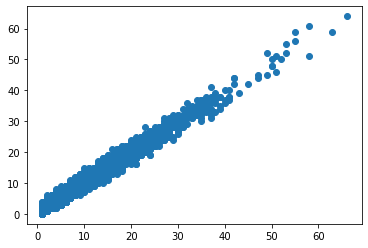

In [32]:
'''
model = LinearRegression()
model.fit(intTrainWF.reshape(-1, 1), pePerTrainWF)
pePerTrainWFInt = np.round(model.predict(intTrainWF.reshape(-1,1)))
plt.scatter(pePerTrainWFInt[:600000], pePerTrainWF[:600000])
plt.show()
'''

In [41]:
'''
print(model.coef_)
print(model.intercept_)
'''

[0.00651683]
0.5644330147776138


In [4]:
# splitPePerTrainWFFinal = np.split(pePerTrainWFFinal, wfIndices[1:-1].astype(int))
splitPePerTrainWFFinal = np.split(pePerTrainWFCalc, wfIndices[1:-1].astype(int))
peTotal = np.empty(p.shape[0])
peMean = np.empty(p.shape[0])
peStd = np.empty(p.shape[0])
peCu3 = np.empty(p.shape[0])
peCu4 = np.empty(p.shape[0])
for index, pePerTrainWFFinalChunk in enumerate(tqdm(splitPePerTrainWFFinal)):
    peTotal[index] = np.sum(pePerTrainWFFinalChunk)
    peMean[index] = np.mean(pePerTrainWFFinalChunk)
    peStd[index] = np.std(pePerTrainWFFinalChunk)
    peCu3[index] = kstat(pePerTrainWFFinalChunk[~np.isnan(pePerTrainWFFinalChunk)], 3)
    peCu4[index] = kstat(pePerTrainWFFinalChunk[~np.isnan(pePerTrainWFFinalChunk)], 4)

splitMeanPeTimePerTrainWF = np.split(meanPeTimePerTrainWF, wfIndices[1:-1].astype(int))
peTimeMean = np.empty(p.shape[0])
peTimeStd = np.empty(p.shape[0])
peTimeCu3 = np.empty(p.shape[0])
peTimeCu4 = np.empty(p.shape[0])
for index, meanPeTimePerTrainWFFinalChunk in enumerate(tqdm(splitMeanPeTimePerTrainWF)):
    peTimeMean[index] = np.nanmean(meanPeTimePerTrainWFFinalChunk)
    peTimeStd[index] = np.nanstd(meanPeTimePerTrainWFFinalChunk)
    peTimeCu3[index] = kstat(meanPeTimePerTrainWFFinalChunk[~np.isnan(meanPeTimePerTrainWFFinalChunk)], 3)
    peTimeCu4[index] = kstat(meanPeTimePerTrainWFFinalChunk[~np.isnan(meanPeTimePerTrainWFFinalChunk)], 4)    

100%|██████████| 35996/35996 [00:31<00:00, 1125.37it/s]


In [5]:
trainDataForP = lgb.Dataset(
    np.stack(
        (peTotal[:-3600],
         peMean[:-3600],
         peStd[:-3600],
         peCu3[:-3600],
         peCu4[:-3600],
         peTimeMean[:-3600],
         peTimeStd[:-3600],
         peTimeCu3[:-3600],
         peTimeCu4[:-3600],
        ),
        axis=1
    ),
    label=p[:-3600]
)
validationDataForP = lgb.Dataset(
    np.stack(
        (peTotal[-3600:],
         peMean[-3600:],
         peStd[-3600:],
         peCu3[-3600:],
         peCu4[-3600:],
         peTimeMean[-3600:],
         peTimeStd[-3600:],
         peTimeCu3[-3600:],
         peTimeCu4[-3600:],
        ),
        axis=1
    ),
    label=p[-3600:],
    reference=trainDataForP
)
trainDataPath = './train/trainDataForP.bin'
validDataPath = './train/validDataForP.bin'
if os.path.exists(trainDataPath):
    os.remove(trainDataPath)
if os.path.exists(validDataPath):
    os.remove(validDataPath)
trainDataForP.save_binary('./train/trainDataForP.bin')
validationDataForP.save_binary('./train/validDataForP.bin')

[LightGBM] [Info] Saving data to binary file ./train/trainDataForP.bin
[LightGBM] [Info] Saving data to binary file ./train/validDataForP.bin


/home/zhaohaimeng/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


In [12]:
trainDataForP = lgb.Dataset('./train/trainDataForP.bin')
validationDataForP = lgb.Dataset('./train/validDataForP.bin')

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'custom'},
    'num_leaves': 2**12,
    'learning_rate': 0.001,
    'feature_fraction': 1,
    'bagging_fraction': 0.1,
    'bagging_freq': 5,
    'verbose': -1,
    'num_threads': 20,
    'max_depth': 12,
    #'device': 'gpu',
    #'gpu_platform_id': -1,
    #'gpu_device_id': -1,
}
gbmForP = lgb.train(
    params,
    trainDataForP,
    num_boost_round=60000,
    valid_sets=validationDataForP,
    early_stopping_rounds=1000,
    fobj=lossfunc_train,
    feval=lossfunc_eval,
)
gbmForP.save_model('model/modelPCalc.txt')

[1]	valid_0's custom: 5.47571
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's custom: 5.46477
[3]	valid_0's custom: 5.45385
[4]	valid_0's custom: 5.44295
[5]	valid_0's custom: 5.43208
[6]	valid_0's custom: 5.42126
[7]	valid_0's custom: 5.41045
[8]	valid_0's custom: 5.39967
[9]	valid_0's custom: 5.38891
[10]	valid_0's custom: 5.37817
[11]	valid_0's custom: 5.36745
[12]	valid_0's custom: 5.35676
[13]	valid_0's custom: 5.34608
[14]	valid_0's custom: 5.33542
[15]	valid_0's custom: 5.32479
[16]	valid_0's custom: 5.31417
[17]	valid_0's custom: 5.30356
[18]	valid_0's custom: 5.29298
[19]	valid_0's custom: 5.28242
[20]	valid_0's custom: 5.27189
[21]	valid_0's custom: 5.26139
[22]	valid_0's custom: 5.25092
[23]	valid_0's custom: 5.24046
[24]	valid_0's custom: 5.23003
[25]	valid_0's custom: 5.21962
[26]	valid_0's custom: 5.20923
[27]	valid_0's custom: 5.19885
[28]	valid_0's custom: 5.18849
[29]	valid_0's custom: 5.17816
[30]	valid_0's custom: 5.16784
[31]	valid_0's c

[276]	valid_0's custom: 3.16338
[277]	valid_0's custom: 3.15709
[278]	valid_0's custom: 3.15081
[279]	valid_0's custom: 3.14454
[280]	valid_0's custom: 3.13829
[281]	valid_0's custom: 3.13204
[282]	valid_0's custom: 3.12581
[283]	valid_0's custom: 3.11958
[284]	valid_0's custom: 3.11337
[285]	valid_0's custom: 3.10718
[286]	valid_0's custom: 3.10099
[287]	valid_0's custom: 3.09481
[288]	valid_0's custom: 3.08864
[289]	valid_0's custom: 3.08249
[290]	valid_0's custom: 3.07634
[291]	valid_0's custom: 3.07022
[292]	valid_0's custom: 3.06411
[293]	valid_0's custom: 3.05802
[294]	valid_0's custom: 3.05193
[295]	valid_0's custom: 3.04586
[296]	valid_0's custom: 3.03979
[297]	valid_0's custom: 3.03373
[298]	valid_0's custom: 3.02768
[299]	valid_0's custom: 3.02165
[300]	valid_0's custom: 3.01563
[301]	valid_0's custom: 3.00963
[302]	valid_0's custom: 3.00365
[303]	valid_0's custom: 2.99767
[304]	valid_0's custom: 2.99171
[305]	valid_0's custom: 2.98577
[306]	valid_0's custom: 2.97981
[307]	va

[562]	valid_0's custom: 1.7898
[563]	valid_0's custom: 1.78624
[564]	valid_0's custom: 1.78269
[565]	valid_0's custom: 1.77914
[566]	valid_0's custom: 1.7756
[567]	valid_0's custom: 1.77208
[568]	valid_0's custom: 1.76856
[569]	valid_0's custom: 1.76504
[570]	valid_0's custom: 1.76154
[571]	valid_0's custom: 1.75804
[572]	valid_0's custom: 1.75454
[573]	valid_0's custom: 1.75105
[574]	valid_0's custom: 1.74757
[575]	valid_0's custom: 1.74409
[576]	valid_0's custom: 1.74062
[577]	valid_0's custom: 1.73716
[578]	valid_0's custom: 1.7337
[579]	valid_0's custom: 1.73026
[580]	valid_0's custom: 1.72682
[581]	valid_0's custom: 1.72339
[582]	valid_0's custom: 1.71997
[583]	valid_0's custom: 1.71655
[584]	valid_0's custom: 1.71314
[585]	valid_0's custom: 1.70974
[586]	valid_0's custom: 1.70634
[587]	valid_0's custom: 1.70295
[588]	valid_0's custom: 1.69957
[589]	valid_0's custom: 1.69619
[590]	valid_0's custom: 1.69282
[591]	valid_0's custom: 1.68945
[592]	valid_0's custom: 1.6861
[593]	valid_

[833]	valid_0's custom: 1.04495
[834]	valid_0's custom: 1.04289
[835]	valid_0's custom: 1.04083
[836]	valid_0's custom: 1.03877
[837]	valid_0's custom: 1.03672
[838]	valid_0's custom: 1.03467
[839]	valid_0's custom: 1.03263
[840]	valid_0's custom: 1.03059
[841]	valid_0's custom: 1.02855
[842]	valid_0's custom: 1.02652
[843]	valid_0's custom: 1.02449
[844]	valid_0's custom: 1.02247
[845]	valid_0's custom: 1.02044
[846]	valid_0's custom: 1.01843
[847]	valid_0's custom: 1.01641
[848]	valid_0's custom: 1.0144
[849]	valid_0's custom: 1.01239
[850]	valid_0's custom: 1.01039
[851]	valid_0's custom: 1.00839
[852]	valid_0's custom: 1.00639
[853]	valid_0's custom: 1.0044
[854]	valid_0's custom: 1.00241
[855]	valid_0's custom: 1.00042
[856]	valid_0's custom: 0.998443
[857]	valid_0's custom: 0.996468
[858]	valid_0's custom: 0.994498
[859]	valid_0's custom: 0.992531
[860]	valid_0's custom: 0.990569
[861]	valid_0's custom: 0.988609
[862]	valid_0's custom: 0.986653
[863]	valid_0's custom: 0.984701
[8

[1104]	valid_0's custom: 0.611507
[1105]	valid_0's custom: 0.610297
[1106]	valid_0's custom: 0.609094
[1107]	valid_0's custom: 0.607894
[1108]	valid_0's custom: 0.606696
[1109]	valid_0's custom: 0.6055
[1110]	valid_0's custom: 0.604307
[1111]	valid_0's custom: 0.603114
[1112]	valid_0's custom: 0.601923
[1113]	valid_0's custom: 0.600734
[1114]	valid_0's custom: 0.599548
[1115]	valid_0's custom: 0.598364
[1116]	valid_0's custom: 0.597186
[1117]	valid_0's custom: 0.59601
[1118]	valid_0's custom: 0.594837
[1119]	valid_0's custom: 0.593666
[1120]	valid_0's custom: 0.592497
[1121]	valid_0's custom: 0.591334
[1122]	valid_0's custom: 0.590174
[1123]	valid_0's custom: 0.589016
[1124]	valid_0's custom: 0.58786
[1125]	valid_0's custom: 0.586707
[1126]	valid_0's custom: 0.585554
[1127]	valid_0's custom: 0.584404
[1128]	valid_0's custom: 0.583256
[1129]	valid_0's custom: 0.58211
[1130]	valid_0's custom: 0.580966
[1131]	valid_0's custom: 0.579827
[1132]	valid_0's custom: 0.57869
[1133]	valid_0's cus

[1382]	valid_0's custom: 0.354549
[1383]	valid_0's custom: 0.353858
[1384]	valid_0's custom: 0.353169
[1385]	valid_0's custom: 0.352481
[1386]	valid_0's custom: 0.351796
[1387]	valid_0's custom: 0.351111
[1388]	valid_0's custom: 0.350428
[1389]	valid_0's custom: 0.349747
[1390]	valid_0's custom: 0.349067
[1391]	valid_0's custom: 0.348388
[1392]	valid_0's custom: 0.34771
[1393]	valid_0's custom: 0.347033
[1394]	valid_0's custom: 0.346358
[1395]	valid_0's custom: 0.345685
[1396]	valid_0's custom: 0.345016
[1397]	valid_0's custom: 0.344349
[1398]	valid_0's custom: 0.343683
[1399]	valid_0's custom: 0.343018
[1400]	valid_0's custom: 0.342355
[1401]	valid_0's custom: 0.341694
[1402]	valid_0's custom: 0.341033
[1403]	valid_0's custom: 0.340374
[1404]	valid_0's custom: 0.339717
[1405]	valid_0's custom: 0.33906
[1406]	valid_0's custom: 0.338401
[1407]	valid_0's custom: 0.337743
[1408]	valid_0's custom: 0.337086
[1409]	valid_0's custom: 0.33643
[1410]	valid_0's custom: 0.335776
[1411]	valid_0's 

[1651]	valid_0's custom: 0.210753
[1652]	valid_0's custom: 0.210347
[1653]	valid_0's custom: 0.209943
[1654]	valid_0's custom: 0.209539
[1655]	valid_0's custom: 0.209137
[1656]	valid_0's custom: 0.208734
[1657]	valid_0's custom: 0.208333
[1658]	valid_0's custom: 0.207932
[1659]	valid_0's custom: 0.207533
[1660]	valid_0's custom: 0.207134
[1661]	valid_0's custom: 0.206736
[1662]	valid_0's custom: 0.20634
[1663]	valid_0's custom: 0.205944
[1664]	valid_0's custom: 0.205549
[1665]	valid_0's custom: 0.205155
[1666]	valid_0's custom: 0.204764
[1667]	valid_0's custom: 0.204374
[1668]	valid_0's custom: 0.203985
[1669]	valid_0's custom: 0.203597
[1670]	valid_0's custom: 0.203209
[1671]	valid_0's custom: 0.202819
[1672]	valid_0's custom: 0.202429
[1673]	valid_0's custom: 0.202041
[1674]	valid_0's custom: 0.201653
[1675]	valid_0's custom: 0.201266
[1676]	valid_0's custom: 0.20088
[1677]	valid_0's custom: 0.200495
[1678]	valid_0's custom: 0.200111
[1679]	valid_0's custom: 0.199727
[1680]	valid_0's

[1926]	valid_0's custom: 0.125216
[1927]	valid_0's custom: 0.124983
[1928]	valid_0's custom: 0.12475
[1929]	valid_0's custom: 0.124518
[1930]	valid_0's custom: 0.124286
[1931]	valid_0's custom: 0.124054
[1932]	valid_0's custom: 0.123822
[1933]	valid_0's custom: 0.12359
[1934]	valid_0's custom: 0.123359
[1935]	valid_0's custom: 0.123129
[1936]	valid_0's custom: 0.1229
[1937]	valid_0's custom: 0.122672
[1938]	valid_0's custom: 0.122444
[1939]	valid_0's custom: 0.122217
[1940]	valid_0's custom: 0.12199
[1941]	valid_0's custom: 0.121763
[1942]	valid_0's custom: 0.121537
[1943]	valid_0's custom: 0.121311
[1944]	valid_0's custom: 0.121085
[1945]	valid_0's custom: 0.12086
[1946]	valid_0's custom: 0.120637
[1947]	valid_0's custom: 0.120414
[1948]	valid_0's custom: 0.120192
[1949]	valid_0's custom: 0.119971
[1950]	valid_0's custom: 0.11975
[1951]	valid_0's custom: 0.119526
[1952]	valid_0's custom: 0.119304
[1953]	valid_0's custom: 0.119082
[1954]	valid_0's custom: 0.11886
[1955]	valid_0's custo

[2204]	valid_0's custom: 0.0754362
[2205]	valid_0's custom: 0.0753025
[2206]	valid_0's custom: 0.0751691
[2207]	valid_0's custom: 0.075036
[2208]	valid_0's custom: 0.0749032
[2209]	valid_0's custom: 0.0747706
[2210]	valid_0's custom: 0.0746382
[2211]	valid_0's custom: 0.074506
[2212]	valid_0's custom: 0.0743741
[2213]	valid_0's custom: 0.0742425
[2214]	valid_0's custom: 0.0741111
[2215]	valid_0's custom: 0.0739799
[2216]	valid_0's custom: 0.0738486
[2217]	valid_0's custom: 0.0737175
[2218]	valid_0's custom: 0.0735866
[2219]	valid_0's custom: 0.0734561
[2220]	valid_0's custom: 0.0733258
[2221]	valid_0's custom: 0.0731966
[2222]	valid_0's custom: 0.0730677
[2223]	valid_0's custom: 0.0729391
[2224]	valid_0's custom: 0.0728107
[2225]	valid_0's custom: 0.0726826
[2226]	valid_0's custom: 0.0725542
[2227]	valid_0's custom: 0.0724261
[2228]	valid_0's custom: 0.0722982
[2229]	valid_0's custom: 0.0721706
[2230]	valid_0's custom: 0.0720432
[2231]	valid_0's custom: 0.0719174
[2232]	valid_0's custo

[2442]	valid_0's custom: 0.0500722
[2443]	valid_0's custom: 0.049989
[2444]	valid_0's custom: 0.0499059
[2445]	valid_0's custom: 0.049823
[2446]	valid_0's custom: 0.0497404
[2447]	valid_0's custom: 0.049658
[2448]	valid_0's custom: 0.0495758
[2449]	valid_0's custom: 0.0494938
[2450]	valid_0's custom: 0.0494119
[2451]	valid_0's custom: 0.0493286
[2452]	valid_0's custom: 0.0492454
[2453]	valid_0's custom: 0.0491624
[2454]	valid_0's custom: 0.0490796
[2455]	valid_0's custom: 0.0489969
[2456]	valid_0's custom: 0.0489167
[2457]	valid_0's custom: 0.0488367
[2458]	valid_0's custom: 0.0487568
[2459]	valid_0's custom: 0.0486771
[2460]	valid_0's custom: 0.0485976
[2461]	valid_0's custom: 0.0485173
[2462]	valid_0's custom: 0.0484372
[2463]	valid_0's custom: 0.0483573
[2464]	valid_0's custom: 0.0482776
[2465]	valid_0's custom: 0.048198
[2466]	valid_0's custom: 0.0481191
[2467]	valid_0's custom: 0.0480405
[2468]	valid_0's custom: 0.0479619
[2469]	valid_0's custom: 0.0478836
[2470]	valid_0's custom:

[2680]	valid_0's custom: 0.0342958
[2681]	valid_0's custom: 0.0342436
[2682]	valid_0's custom: 0.0341914
[2683]	valid_0's custom: 0.0341394
[2684]	valid_0's custom: 0.0340874
[2685]	valid_0's custom: 0.0340356
[2686]	valid_0's custom: 0.0339852
[2687]	valid_0's custom: 0.033935
[2688]	valid_0's custom: 0.0338848
[2689]	valid_0's custom: 0.0338348
[2690]	valid_0's custom: 0.0337848
[2691]	valid_0's custom: 0.0337329
[2692]	valid_0's custom: 0.0336812
[2693]	valid_0's custom: 0.0336296
[2694]	valid_0's custom: 0.033578
[2695]	valid_0's custom: 0.0335266
[2696]	valid_0's custom: 0.0334761
[2697]	valid_0's custom: 0.0334257
[2698]	valid_0's custom: 0.0333753
[2699]	valid_0's custom: 0.0333251
[2700]	valid_0's custom: 0.033275
[2701]	valid_0's custom: 0.0332251
[2702]	valid_0's custom: 0.0331753
[2703]	valid_0's custom: 0.0331257
[2704]	valid_0's custom: 0.0330761
[2705]	valid_0's custom: 0.0330267
[2706]	valid_0's custom: 0.0329783
[2707]	valid_0's custom: 0.0329299
[2708]	valid_0's custom

[2915]	valid_0's custom: 0.0245902
[2916]	valid_0's custom: 0.0245572
[2917]	valid_0's custom: 0.0245243
[2918]	valid_0's custom: 0.0244915
[2919]	valid_0's custom: 0.0244587
[2920]	valid_0's custom: 0.024426
[2921]	valid_0's custom: 0.0243929
[2922]	valid_0's custom: 0.0243599
[2923]	valid_0's custom: 0.024327
[2924]	valid_0's custom: 0.0242941
[2925]	valid_0's custom: 0.0242613
[2926]	valid_0's custom: 0.02423
[2927]	valid_0's custom: 0.0241987
[2928]	valid_0's custom: 0.0241675
[2929]	valid_0's custom: 0.0241364
[2930]	valid_0's custom: 0.0241052
[2931]	valid_0's custom: 0.0240743
[2932]	valid_0's custom: 0.0240435
[2933]	valid_0's custom: 0.0240128
[2934]	valid_0's custom: 0.0239821
[2935]	valid_0's custom: 0.0239515
[2936]	valid_0's custom: 0.0239197
[2937]	valid_0's custom: 0.023888
[2938]	valid_0's custom: 0.0238563
[2939]	valid_0's custom: 0.0238247
[2940]	valid_0's custom: 0.0237932
[2941]	valid_0's custom: 0.0237624
[2942]	valid_0's custom: 0.0237317
[2943]	valid_0's custom: 

[3156]	valid_0's custom: 0.0183907
[3157]	valid_0's custom: 0.0183706
[3158]	valid_0's custom: 0.0183504
[3159]	valid_0's custom: 0.0183303
[3160]	valid_0's custom: 0.0183103
[3161]	valid_0's custom: 0.0182904
[3162]	valid_0's custom: 0.0182707
[3163]	valid_0's custom: 0.0182509
[3164]	valid_0's custom: 0.0182312
[3165]	valid_0's custom: 0.0182115
[3166]	valid_0's custom: 0.0181914
[3167]	valid_0's custom: 0.0181714
[3168]	valid_0's custom: 0.0181514
[3169]	valid_0's custom: 0.0181314
[3170]	valid_0's custom: 0.0181115
[3171]	valid_0's custom: 0.0180913
[3172]	valid_0's custom: 0.0180711
[3173]	valid_0's custom: 0.0180509
[3174]	valid_0's custom: 0.0180309
[3175]	valid_0's custom: 0.0180108
[3176]	valid_0's custom: 0.0179915
[3177]	valid_0's custom: 0.0179723
[3178]	valid_0's custom: 0.0179532
[3179]	valid_0's custom: 0.0179341
[3180]	valid_0's custom: 0.017915
[3181]	valid_0's custom: 0.0178957
[3182]	valid_0's custom: 0.0178764
[3183]	valid_0's custom: 0.0178571
[3184]	valid_0's cust

[3402]	valid_0's custom: 0.0144882
[3403]	valid_0's custom: 0.0144759
[3404]	valid_0's custom: 0.0144636
[3405]	valid_0's custom: 0.0144514
[3406]	valid_0's custom: 0.0144386
[3407]	valid_0's custom: 0.0144259
[3408]	valid_0's custom: 0.0144131
[3409]	valid_0's custom: 0.0144004
[3410]	valid_0's custom: 0.0143877
[3411]	valid_0's custom: 0.0143757
[3412]	valid_0's custom: 0.0143637
[3413]	valid_0's custom: 0.0143518
[3414]	valid_0's custom: 0.0143398
[3415]	valid_0's custom: 0.0143279
[3416]	valid_0's custom: 0.0143159
[3417]	valid_0's custom: 0.014304
[3418]	valid_0's custom: 0.0142922
[3419]	valid_0's custom: 0.0142803
[3420]	valid_0's custom: 0.0142685
[3421]	valid_0's custom: 0.0142565
[3422]	valid_0's custom: 0.0142445
[3423]	valid_0's custom: 0.0142326
[3424]	valid_0's custom: 0.0142207
[3425]	valid_0's custom: 0.0142088
[3426]	valid_0's custom: 0.014197
[3427]	valid_0's custom: 0.0141851
[3428]	valid_0's custom: 0.0141733
[3429]	valid_0's custom: 0.0141615
[3430]	valid_0's custo

[3642]	valid_0's custom: 0.012142
[3643]	valid_0's custom: 0.0121347
[3644]	valid_0's custom: 0.0121275
[3645]	valid_0's custom: 0.0121204
[3646]	valid_0's custom: 0.0121131
[3647]	valid_0's custom: 0.0121059
[3648]	valid_0's custom: 0.0120987
[3649]	valid_0's custom: 0.0120915
[3650]	valid_0's custom: 0.0120843
[3651]	valid_0's custom: 0.0120768
[3652]	valid_0's custom: 0.0120692
[3653]	valid_0's custom: 0.0120617
[3654]	valid_0's custom: 0.0120542
[3655]	valid_0's custom: 0.0120467
[3656]	valid_0's custom: 0.0120388
[3657]	valid_0's custom: 0.0120309
[3658]	valid_0's custom: 0.012023
[3659]	valid_0's custom: 0.0120151
[3660]	valid_0's custom: 0.0120073
[3661]	valid_0's custom: 0.0120002
[3662]	valid_0's custom: 0.0119932
[3663]	valid_0's custom: 0.0119862
[3664]	valid_0's custom: 0.0119793
[3665]	valid_0's custom: 0.0119723
[3666]	valid_0's custom: 0.0119655
[3667]	valid_0's custom: 0.0119587
[3668]	valid_0's custom: 0.011952
[3669]	valid_0's custom: 0.0119453
[3670]	valid_0's custom

[3896]	valid_0's custom: 0.0106157
[3897]	valid_0's custom: 0.0106109
[3898]	valid_0's custom: 0.0106062
[3899]	valid_0's custom: 0.0106015
[3900]	valid_0's custom: 0.0105968
[3901]	valid_0's custom: 0.0105919
[3902]	valid_0's custom: 0.010587
[3903]	valid_0's custom: 0.010582
[3904]	valid_0's custom: 0.0105771
[3905]	valid_0's custom: 0.0105722
[3906]	valid_0's custom: 0.0105676
[3907]	valid_0's custom: 0.0105631
[3908]	valid_0's custom: 0.0105586
[3909]	valid_0's custom: 0.0105541
[3910]	valid_0's custom: 0.0105497
[3911]	valid_0's custom: 0.010544
[3912]	valid_0's custom: 0.0105383
[3913]	valid_0's custom: 0.0105327
[3914]	valid_0's custom: 0.0105271
[3915]	valid_0's custom: 0.0105215
[3916]	valid_0's custom: 0.0105167
[3917]	valid_0's custom: 0.010512
[3918]	valid_0's custom: 0.0105071
[3919]	valid_0's custom: 0.0105024
[3920]	valid_0's custom: 0.0104976
[3921]	valid_0's custom: 0.0104935
[3922]	valid_0's custom: 0.0104893
[3923]	valid_0's custom: 0.0104852
[3924]	valid_0's custom:

[4153]	valid_0's custom: 0.00966045
[4154]	valid_0's custom: 0.00965793
[4155]	valid_0's custom: 0.00965541
[4156]	valid_0's custom: 0.00965261
[4157]	valid_0's custom: 0.00964982
[4158]	valid_0's custom: 0.00964703
[4159]	valid_0's custom: 0.00964425
[4160]	valid_0's custom: 0.00964148
[4161]	valid_0's custom: 0.00963904
[4162]	valid_0's custom: 0.00963661
[4163]	valid_0's custom: 0.00963419
[4164]	valid_0's custom: 0.00963178
[4165]	valid_0's custom: 0.00962937
[4166]	valid_0's custom: 0.00962671
[4167]	valid_0's custom: 0.00962407
[4168]	valid_0's custom: 0.00962143
[4169]	valid_0's custom: 0.00961879
[4170]	valid_0's custom: 0.00961617
[4171]	valid_0's custom: 0.00961373
[4172]	valid_0's custom: 0.0096113
[4173]	valid_0's custom: 0.00960886
[4174]	valid_0's custom: 0.00960642
[4175]	valid_0's custom: 0.009604
[4176]	valid_0's custom: 0.00960196
[4177]	valid_0's custom: 0.00959993
[4178]	valid_0's custom: 0.00959792
[4179]	valid_0's custom: 0.00959591
[4180]	valid_0's custom: 0.0095

[4420]	valid_0's custom: 0.00906893
[4421]	valid_0's custom: 0.00906729
[4422]	valid_0's custom: 0.00906563
[4423]	valid_0's custom: 0.009064
[4424]	valid_0's custom: 0.00906236
[4425]	valid_0's custom: 0.00906074
[4426]	valid_0's custom: 0.00905886
[4427]	valid_0's custom: 0.009057
[4428]	valid_0's custom: 0.00905502
[4429]	valid_0's custom: 0.00905316
[4430]	valid_0's custom: 0.00905119
[4431]	valid_0's custom: 0.00904991
[4432]	valid_0's custom: 0.00904864
[4433]	valid_0's custom: 0.00904738
[4434]	valid_0's custom: 0.00904612
[4435]	valid_0's custom: 0.00904486
[4436]	valid_0's custom: 0.00904299
[4437]	valid_0's custom: 0.00904112
[4438]	valid_0's custom: 0.00903925
[4439]	valid_0's custom: 0.00903727
[4440]	valid_0's custom: 0.00903542
[4441]	valid_0's custom: 0.00903372
[4442]	valid_0's custom: 0.00903203
[4443]	valid_0's custom: 0.00903034
[4444]	valid_0's custom: 0.00902867
[4445]	valid_0's custom: 0.00902699
[4446]	valid_0's custom: 0.00902561
[4447]	valid_0's custom: 0.00902

[4666]	valid_0's custom: 0.0087373
[4667]	valid_0's custom: 0.00873624
[4668]	valid_0's custom: 0.00873517
[4669]	valid_0's custom: 0.00873412
[4670]	valid_0's custom: 0.00873306
[4671]	valid_0's custom: 0.00873239
[4672]	valid_0's custom: 0.00873172
[4673]	valid_0's custom: 0.00873105
[4674]	valid_0's custom: 0.00873037
[4675]	valid_0's custom: 0.00872968
[4676]	valid_0's custom: 0.00872885
[4677]	valid_0's custom: 0.00872802
[4678]	valid_0's custom: 0.00872719
[4679]	valid_0's custom: 0.00872636
[4680]	valid_0's custom: 0.00872554
[4681]	valid_0's custom: 0.00872429
[4682]	valid_0's custom: 0.00872305
[4683]	valid_0's custom: 0.00872181
[4684]	valid_0's custom: 0.00872057
[4685]	valid_0's custom: 0.00871934
[4686]	valid_0's custom: 0.00871834
[4687]	valid_0's custom: 0.00871733
[4688]	valid_0's custom: 0.00871634
[4689]	valid_0's custom: 0.00871534
[4690]	valid_0's custom: 0.00871435
[4691]	valid_0's custom: 0.00871346
[4692]	valid_0's custom: 0.00871257
[4693]	valid_0's custom: 0.00

[4924]	valid_0's custom: 0.0085257
[4925]	valid_0's custom: 0.00852523
[4926]	valid_0's custom: 0.00852463
[4927]	valid_0's custom: 0.00852401
[4928]	valid_0's custom: 0.00852342
[4929]	valid_0's custom: 0.0085228
[4930]	valid_0's custom: 0.00852221
[4931]	valid_0's custom: 0.00852143
[4932]	valid_0's custom: 0.00852066
[4933]	valid_0's custom: 0.0085199
[4934]	valid_0's custom: 0.00851915
[4935]	valid_0's custom: 0.00851839
[4936]	valid_0's custom: 0.0085178
[4937]	valid_0's custom: 0.00851722
[4938]	valid_0's custom: 0.00851664
[4939]	valid_0's custom: 0.00851606
[4940]	valid_0's custom: 0.00851549
[4941]	valid_0's custom: 0.00851515
[4942]	valid_0's custom: 0.00851482
[4943]	valid_0's custom: 0.00851448
[4944]	valid_0's custom: 0.00851415
[4945]	valid_0's custom: 0.00851382
[4946]	valid_0's custom: 0.00851291
[4947]	valid_0's custom: 0.00851199
[4948]	valid_0's custom: 0.00851108
[4949]	valid_0's custom: 0.00851017
[4950]	valid_0's custom: 0.00850927
[4951]	valid_0's custom: 0.00850

[5195]	valid_0's custom: 0.00838161
[5196]	valid_0's custom: 0.00838146
[5197]	valid_0's custom: 0.0083813
[5198]	valid_0's custom: 0.00838115
[5199]	valid_0's custom: 0.008381
[5200]	valid_0's custom: 0.00838086
[5201]	valid_0's custom: 0.00838046
[5202]	valid_0's custom: 0.00838006
[5203]	valid_0's custom: 0.00837967
[5204]	valid_0's custom: 0.00837927
[5205]	valid_0's custom: 0.00837888
[5206]	valid_0's custom: 0.0083776
[5207]	valid_0's custom: 0.00837635
[5208]	valid_0's custom: 0.00837507
[5209]	valid_0's custom: 0.00837384
[5210]	valid_0's custom: 0.00837257
[5211]	valid_0's custom: 0.00837169
[5212]	valid_0's custom: 0.00837082
[5213]	valid_0's custom: 0.00836993
[5214]	valid_0's custom: 0.00836906
[5215]	valid_0's custom: 0.00836819
[5216]	valid_0's custom: 0.00836767
[5217]	valid_0's custom: 0.00836716
[5218]	valid_0's custom: 0.00836666
[5219]	valid_0's custom: 0.00836616
[5220]	valid_0's custom: 0.00836567
[5221]	valid_0's custom: 0.00836514
[5222]	valid_0's custom: 0.00836

[5433]	valid_0's custom: 0.00831278
[5434]	valid_0's custom: 0.0083129
[5435]	valid_0's custom: 0.00831304
[5436]	valid_0's custom: 0.00831289
[5437]	valid_0's custom: 0.00831274
[5438]	valid_0's custom: 0.0083126
[5439]	valid_0's custom: 0.00831246
[5440]	valid_0's custom: 0.00831231
[5441]	valid_0's custom: 0.00831231
[5442]	valid_0's custom: 0.00831231
[5443]	valid_0's custom: 0.00831231
[5444]	valid_0's custom: 0.00831232
[5445]	valid_0's custom: 0.00831233
[5446]	valid_0's custom: 0.00831161
[5447]	valid_0's custom: 0.00831089
[5448]	valid_0's custom: 0.00831017
[5449]	valid_0's custom: 0.00830946
[5450]	valid_0's custom: 0.00830875
[5451]	valid_0's custom: 0.00830768
[5452]	valid_0's custom: 0.00830662
[5453]	valid_0's custom: 0.00830556
[5454]	valid_0's custom: 0.00830451
[5455]	valid_0's custom: 0.00830346
[5456]	valid_0's custom: 0.00830362
[5457]	valid_0's custom: 0.00830379
[5458]	valid_0's custom: 0.00830395
[5459]	valid_0's custom: 0.00830412
[5460]	valid_0's custom: 0.008

[5681]	valid_0's custom: 0.00825953
[5682]	valid_0's custom: 0.0082593
[5683]	valid_0's custom: 0.00825907
[5684]	valid_0's custom: 0.00825884
[5685]	valid_0's custom: 0.00825862
[5686]	valid_0's custom: 0.00825841
[5687]	valid_0's custom: 0.00825821
[5688]	valid_0's custom: 0.00825802
[5689]	valid_0's custom: 0.00825782
[5690]	valid_0's custom: 0.00825763
[5691]	valid_0's custom: 0.0082576
[5692]	valid_0's custom: 0.00825757
[5693]	valid_0's custom: 0.00825753
[5694]	valid_0's custom: 0.0082575
[5695]	valid_0's custom: 0.00825747
[5696]	valid_0's custom: 0.00825749
[5697]	valid_0's custom: 0.00825752
[5698]	valid_0's custom: 0.00825754
[5699]	valid_0's custom: 0.00825757
[5700]	valid_0's custom: 0.0082576
[5701]	valid_0's custom: 0.00825764
[5702]	valid_0's custom: 0.00825769
[5703]	valid_0's custom: 0.00825774
[5704]	valid_0's custom: 0.00825778
[5705]	valid_0's custom: 0.00825783
[5706]	valid_0's custom: 0.00825736
[5707]	valid_0's custom: 0.00825689
[5708]	valid_0's custom: 0.00825

[5965]	valid_0's custom: 0.0082275
[5966]	valid_0's custom: 0.00822788
[5967]	valid_0's custom: 0.00822824
[5968]	valid_0's custom: 0.0082286
[5969]	valid_0's custom: 0.00822897
[5970]	valid_0's custom: 0.00822934
[5971]	valid_0's custom: 0.00822915
[5972]	valid_0's custom: 0.00822896
[5973]	valid_0's custom: 0.00822877
[5974]	valid_0's custom: 0.00822859
[5975]	valid_0's custom: 0.0082284
[5976]	valid_0's custom: 0.00822819
[5977]	valid_0's custom: 0.00822799
[5978]	valid_0's custom: 0.00822779
[5979]	valid_0's custom: 0.00822758
[5980]	valid_0's custom: 0.00822738
[5981]	valid_0's custom: 0.00822753
[5982]	valid_0's custom: 0.00822769
[5983]	valid_0's custom: 0.00822785
[5984]	valid_0's custom: 0.00822801
[5985]	valid_0's custom: 0.00822816
[5986]	valid_0's custom: 0.00822785
[5987]	valid_0's custom: 0.00822754
[5988]	valid_0's custom: 0.00822723
[5989]	valid_0's custom: 0.00822692
[5990]	valid_0's custom: 0.00822662
[5991]	valid_0's custom: 0.00822637
[5992]	valid_0's custom: 0.0082

[6254]	valid_0's custom: 0.00819553
[6255]	valid_0's custom: 0.00819624
[6256]	valid_0's custom: 0.0081956
[6257]	valid_0's custom: 0.00819495
[6258]	valid_0's custom: 0.00819431
[6259]	valid_0's custom: 0.00819368
[6260]	valid_0's custom: 0.00819304
[6261]	valid_0's custom: 0.00819291
[6262]	valid_0's custom: 0.00819277
[6263]	valid_0's custom: 0.00819264
[6264]	valid_0's custom: 0.0081925
[6265]	valid_0's custom: 0.00819237
[6266]	valid_0's custom: 0.00819241
[6267]	valid_0's custom: 0.00819245
[6268]	valid_0's custom: 0.0081925
[6269]	valid_0's custom: 0.00819254
[6270]	valid_0's custom: 0.00819259
[6271]	valid_0's custom: 0.00819255
[6272]	valid_0's custom: 0.00819252
[6273]	valid_0's custom: 0.00819249
[6274]	valid_0's custom: 0.00819246
[6275]	valid_0's custom: 0.00819244
[6276]	valid_0's custom: 0.00819243
[6277]	valid_0's custom: 0.00819242
[6278]	valid_0's custom: 0.00819242
[6279]	valid_0's custom: 0.00819242
[6280]	valid_0's custom: 0.00819242
[6281]	valid_0's custom: 0.0081

[6549]	valid_0's custom: 0.00819474
[6550]	valid_0's custom: 0.00819481
[6551]	valid_0's custom: 0.00819475
[6552]	valid_0's custom: 0.00819469
[6553]	valid_0's custom: 0.00819464
[6554]	valid_0's custom: 0.00819459
[6555]	valid_0's custom: 0.00819454
[6556]	valid_0's custom: 0.00819482
[6557]	valid_0's custom: 0.00819511
[6558]	valid_0's custom: 0.00819539
[6559]	valid_0's custom: 0.00819568
[6560]	valid_0's custom: 0.00819597
[6561]	valid_0's custom: 0.00819609
[6562]	valid_0's custom: 0.00819621
[6563]	valid_0's custom: 0.00819651
[6564]	valid_0's custom: 0.00819663
[6565]	valid_0's custom: 0.00819693
[6566]	valid_0's custom: 0.00819683
[6567]	valid_0's custom: 0.00819674
[6568]	valid_0's custom: 0.00819664
[6569]	valid_0's custom: 0.00819655
[6570]	valid_0's custom: 0.00819645
[6571]	valid_0's custom: 0.00819659
[6572]	valid_0's custom: 0.00819674
[6573]	valid_0's custom: 0.00819688
[6574]	valid_0's custom: 0.00819703
[6575]	valid_0's custom: 0.00819718
[6576]	valid_0's custom: 0.0

[6780]	valid_0's custom: 0.00818835
[6781]	valid_0's custom: 0.00818831
[6782]	valid_0's custom: 0.00818826
[6783]	valid_0's custom: 0.00818821
[6784]	valid_0's custom: 0.00818817
[6785]	valid_0's custom: 0.00818812
[6786]	valid_0's custom: 0.00818809
[6787]	valid_0's custom: 0.00818807
[6788]	valid_0's custom: 0.00818804
[6789]	valid_0's custom: 0.008188
[6790]	valid_0's custom: 0.00818798
[6791]	valid_0's custom: 0.00818806
[6792]	valid_0's custom: 0.00818813
[6793]	valid_0's custom: 0.00818824
[6794]	valid_0's custom: 0.00818832
[6795]	valid_0's custom: 0.00818843
[6796]	valid_0's custom: 0.00818853
[6797]	valid_0's custom: 0.00818864
[6798]	valid_0's custom: 0.00818874
[6799]	valid_0's custom: 0.00818885
[6800]	valid_0's custom: 0.00818895
[6801]	valid_0's custom: 0.00818895
[6802]	valid_0's custom: 0.00818894
[6803]	valid_0's custom: 0.00818894
[6804]	valid_0's custom: 0.00818893
[6805]	valid_0's custom: 0.00818893
[6806]	valid_0's custom: 0.00818931
[6807]	valid_0's custom: 0.008

[7015]	valid_0's custom: 0.00817736
[7016]	valid_0's custom: 0.00817726
[7017]	valid_0's custom: 0.00817717
[7018]	valid_0's custom: 0.00817708
[7019]	valid_0's custom: 0.00817699
[7020]	valid_0's custom: 0.0081769
[7021]	valid_0's custom: 0.00817668
[7022]	valid_0's custom: 0.00817646
[7023]	valid_0's custom: 0.00817624
[7024]	valid_0's custom: 0.00817602
[7025]	valid_0's custom: 0.00817581
[7026]	valid_0's custom: 0.00817604
[7027]	valid_0's custom: 0.00817627
[7028]	valid_0's custom: 0.0081765
[7029]	valid_0's custom: 0.00817673
[7030]	valid_0's custom: 0.00817696
[7031]	valid_0's custom: 0.00817699
[7032]	valid_0's custom: 0.00817703
[7033]	valid_0's custom: 0.00817707
[7034]	valid_0's custom: 0.0081771
[7035]	valid_0's custom: 0.00817714
[7036]	valid_0's custom: 0.00817747
[7037]	valid_0's custom: 0.0081778
[7038]	valid_0's custom: 0.00817813
[7039]	valid_0's custom: 0.00817846
[7040]	valid_0's custom: 0.00817879
[7041]	valid_0's custom: 0.0081784
[7042]	valid_0's custom: 0.008178

[7259]	valid_0's custom: 0.00816157
[7260]	valid_0's custom: 0.00816159
[7261]	valid_0's custom: 0.00816184
[7262]	valid_0's custom: 0.0081621
[7263]	valid_0's custom: 0.00816235
[7264]	valid_0's custom: 0.00816261
[7265]	valid_0's custom: 0.00816288
[7266]	valid_0's custom: 0.00816211
[7267]	valid_0's custom: 0.00816135
[7268]	valid_0's custom: 0.00816059
[7269]	valid_0's custom: 0.00815984
[7270]	valid_0's custom: 0.00815909
[7271]	valid_0's custom: 0.00815925
[7272]	valid_0's custom: 0.0081594
[7273]	valid_0's custom: 0.00815956
[7274]	valid_0's custom: 0.00815971
[7275]	valid_0's custom: 0.00815987
[7276]	valid_0's custom: 0.00815978
[7277]	valid_0's custom: 0.00815969
[7278]	valid_0's custom: 0.0081596
[7279]	valid_0's custom: 0.00815952
[7280]	valid_0's custom: 0.00815943
[7281]	valid_0's custom: 0.00815928
[7282]	valid_0's custom: 0.00815912
[7283]	valid_0's custom: 0.00815897
[7284]	valid_0's custom: 0.00815882
[7285]	valid_0's custom: 0.00815868
[7286]	valid_0's custom: 0.0081

[7521]	valid_0's custom: 0.00814991
[7522]	valid_0's custom: 0.00814977
[7523]	valid_0's custom: 0.00814962
[7524]	valid_0's custom: 0.00814948
[7525]	valid_0's custom: 0.00814934
[7526]	valid_0's custom: 0.00814917
[7527]	valid_0's custom: 0.008149
[7528]	valid_0's custom: 0.00814884
[7529]	valid_0's custom: 0.00814868
[7530]	valid_0's custom: 0.00814852
[7531]	valid_0's custom: 0.00814871
[7532]	valid_0's custom: 0.0081489
[7533]	valid_0's custom: 0.0081491
[7534]	valid_0's custom: 0.00814929
[7535]	valid_0's custom: 0.00814949
[7536]	valid_0's custom: 0.00814908
[7537]	valid_0's custom: 0.00814867
[7538]	valid_0's custom: 0.00814827
[7539]	valid_0's custom: 0.00814787
[7540]	valid_0's custom: 0.00814747
[7541]	valid_0's custom: 0.00814713
[7542]	valid_0's custom: 0.00814679
[7543]	valid_0's custom: 0.00814645
[7544]	valid_0's custom: 0.00814612
[7545]	valid_0's custom: 0.00814578
[7546]	valid_0's custom: 0.00814608
[7547]	valid_0's custom: 0.00814638
[7548]	valid_0's custom: 0.00814

[7770]	valid_0's custom: 0.00813684
[7771]	valid_0's custom: 0.00813689
[7772]	valid_0's custom: 0.00813694
[7773]	valid_0's custom: 0.00813699
[7774]	valid_0's custom: 0.00813705
[7775]	valid_0's custom: 0.00813711
[7776]	valid_0's custom: 0.0081374
[7777]	valid_0's custom: 0.00813769
[7778]	valid_0's custom: 0.00813798
[7779]	valid_0's custom: 0.00813828
[7780]	valid_0's custom: 0.00813857
[7781]	valid_0's custom: 0.00813819
[7782]	valid_0's custom: 0.00813782
[7783]	valid_0's custom: 0.00813744
[7784]	valid_0's custom: 0.00813708
[7785]	valid_0's custom: 0.00813671
[7786]	valid_0's custom: 0.00813708
[7787]	valid_0's custom: 0.00813746
[7788]	valid_0's custom: 0.00813783
[7789]	valid_0's custom: 0.00813818
[7790]	valid_0's custom: 0.00813854
[7791]	valid_0's custom: 0.00813877
[7792]	valid_0's custom: 0.008139
[7793]	valid_0's custom: 0.00813923
[7794]	valid_0's custom: 0.00813946
[7795]	valid_0's custom: 0.00813969
[7796]	valid_0's custom: 0.00813973
[7797]	valid_0's custom: 0.0081

[8053]	valid_0's custom: 0.00812589
[8054]	valid_0's custom: 0.00812594
[8055]	valid_0's custom: 0.00812598
[8056]	valid_0's custom: 0.0081258
[8057]	valid_0's custom: 0.00812561
[8058]	valid_0's custom: 0.00812543
[8059]	valid_0's custom: 0.00812525
[8060]	valid_0's custom: 0.00812507
[8061]	valid_0's custom: 0.00812496
[8062]	valid_0's custom: 0.00812485
[8063]	valid_0's custom: 0.00812474
[8064]	valid_0's custom: 0.00812464
[8065]	valid_0's custom: 0.00812454
[8066]	valid_0's custom: 0.00812467
[8067]	valid_0's custom: 0.0081248
[8068]	valid_0's custom: 0.00812493
[8069]	valid_0's custom: 0.00812507
[8070]	valid_0's custom: 0.00812521
[8071]	valid_0's custom: 0.00812547
[8072]	valid_0's custom: 0.00812573
[8073]	valid_0's custom: 0.00812599
[8074]	valid_0's custom: 0.00812625
[8075]	valid_0's custom: 0.00812652
[8076]	valid_0's custom: 0.00812665
[8077]	valid_0's custom: 0.00812679
[8078]	valid_0's custom: 0.00812693
[8079]	valid_0's custom: 0.0081271
[8080]	valid_0's custom: 0.0081

[8295]	valid_0's custom: 0.0081298
[8296]	valid_0's custom: 0.00812955
[8297]	valid_0's custom: 0.0081293
[8298]	valid_0's custom: 0.00812906
[8299]	valid_0's custom: 0.00812881
[8300]	valid_0's custom: 0.00812857
[8301]	valid_0's custom: 0.00812858
[8302]	valid_0's custom: 0.00812859
[8303]	valid_0's custom: 0.0081287
[8304]	valid_0's custom: 0.00812871
[8305]	valid_0's custom: 0.00812882
[8306]	valid_0's custom: 0.00812897
[8307]	valid_0's custom: 0.00812913
[8308]	valid_0's custom: 0.00812929
[8309]	valid_0's custom: 0.00812944
[8310]	valid_0's custom: 0.0081296
[8311]	valid_0's custom: 0.00812982
[8312]	valid_0's custom: 0.00813004
[8313]	valid_0's custom: 0.00813026
[8314]	valid_0's custom: 0.00813049
[8315]	valid_0's custom: 0.00813071
[8316]	valid_0's custom: 0.00813019
[8317]	valid_0's custom: 0.00812967
[8318]	valid_0's custom: 0.00812914
[8319]	valid_0's custom: 0.00812863
[8320]	valid_0's custom: 0.00812811
[8321]	valid_0's custom: 0.00812842
[8322]	valid_0's custom: 0.00812

[8529]	valid_0's custom: 0.00813417
[8530]	valid_0's custom: 0.00813433
[8531]	valid_0's custom: 0.00813433
[8532]	valid_0's custom: 0.00813433
[8533]	valid_0's custom: 0.00813432
[8534]	valid_0's custom: 0.00813432
[8535]	valid_0's custom: 0.00813431
[8536]	valid_0's custom: 0.00813427
[8537]	valid_0's custom: 0.00813424
[8538]	valid_0's custom: 0.00813421
[8539]	valid_0's custom: 0.00813418
[8540]	valid_0's custom: 0.00813415
[8541]	valid_0's custom: 0.00813446
[8542]	valid_0's custom: 0.00813478
[8543]	valid_0's custom: 0.00813509
[8544]	valid_0's custom: 0.00813541
[8545]	valid_0's custom: 0.00813572
[8546]	valid_0's custom: 0.00813561
[8547]	valid_0's custom: 0.00813541
[8548]	valid_0's custom: 0.00813521
[8549]	valid_0's custom: 0.0081351
[8550]	valid_0's custom: 0.0081349
[8551]	valid_0's custom: 0.00813493
[8552]	valid_0's custom: 0.00813495
[8553]	valid_0's custom: 0.00813497
[8554]	valid_0's custom: 0.008135
[8555]	valid_0's custom: 0.00813502
[8556]	valid_0's custom: 0.00813

[8762]	valid_0's custom: 0.00813081
[8763]	valid_0's custom: 0.00813066
[8764]	valid_0's custom: 0.00813053
[8765]	valid_0's custom: 0.00813039
[8766]	valid_0's custom: 0.00813037
[8767]	valid_0's custom: 0.00813036
[8768]	valid_0's custom: 0.00813035
[8769]	valid_0's custom: 0.00813034
[8770]	valid_0's custom: 0.00813034
[8771]	valid_0's custom: 0.0081305
[8772]	valid_0's custom: 0.00813067
[8773]	valid_0's custom: 0.00813084
[8774]	valid_0's custom: 0.00813101
[8775]	valid_0's custom: 0.00813119
[8776]	valid_0's custom: 0.00813124
[8777]	valid_0's custom: 0.00813129
[8778]	valid_0's custom: 0.00813133
[8779]	valid_0's custom: 0.00813139
[8780]	valid_0's custom: 0.00813144
[8781]	valid_0's custom: 0.00813161
[8782]	valid_0's custom: 0.00813178
[8783]	valid_0's custom: 0.00813195
[8784]	valid_0's custom: 0.00813212
[8785]	valid_0's custom: 0.00813229
[8786]	valid_0's custom: 0.00813238
[8787]	valid_0's custom: 0.00813246
[8788]	valid_0's custom: 0.00813237
[8789]	valid_0's custom: 0.00

[8997]	valid_0's custom: 0.00814083
[8998]	valid_0's custom: 0.00814084
[8999]	valid_0's custom: 0.00814085
[9000]	valid_0's custom: 0.00814086
[9001]	valid_0's custom: 0.00814153
[9002]	valid_0's custom: 0.0081422
[9003]	valid_0's custom: 0.00814288
[9004]	valid_0's custom: 0.00814355
[9005]	valid_0's custom: 0.00814423
[9006]	valid_0's custom: 0.0081444
[9007]	valid_0's custom: 0.00814458
[9008]	valid_0's custom: 0.00814475
[9009]	valid_0's custom: 0.00814493
[9010]	valid_0's custom: 0.00814508
[9011]	valid_0's custom: 0.0081452
[9012]	valid_0's custom: 0.00814532
[9013]	valid_0's custom: 0.00814545
[9014]	valid_0's custom: 0.00814557
[9015]	valid_0's custom: 0.0081457
[9016]	valid_0's custom: 0.00814567
[9017]	valid_0's custom: 0.00814565
[9018]	valid_0's custom: 0.00814563
[9019]	valid_0's custom: 0.00814561
[9020]	valid_0's custom: 0.00814559
[9021]	valid_0's custom: 0.00814553
[9022]	valid_0's custom: 0.00814546
[9023]	valid_0's custom: 0.0081454
[9024]	valid_0's custom: 0.008145

[9244]	valid_0's custom: 0.00814654
[9245]	valid_0's custom: 0.00814672
[9246]	valid_0's custom: 0.00814696
[9247]	valid_0's custom: 0.00814721
[9248]	valid_0's custom: 0.00814745
[9249]	valid_0's custom: 0.0081477
[9250]	valid_0's custom: 0.00814794
[9251]	valid_0's custom: 0.00814771
[9252]	valid_0's custom: 0.00814749
[9253]	valid_0's custom: 0.00814726
[9254]	valid_0's custom: 0.00814704
[9255]	valid_0's custom: 0.00814681
[9256]	valid_0's custom: 0.00814692
[9257]	valid_0's custom: 0.00814703
[9258]	valid_0's custom: 0.00814715
[9259]	valid_0's custom: 0.00814726
[9260]	valid_0's custom: 0.00814737
[9261]	valid_0's custom: 0.00814755
[9262]	valid_0's custom: 0.00814772
[9263]	valid_0's custom: 0.0081479
[9264]	valid_0's custom: 0.00814802
[9265]	valid_0's custom: 0.00814815
[9266]	valid_0's custom: 0.00814822
[9267]	valid_0's custom: 0.0081483
[9268]	valid_0's custom: 0.00814838
[9269]	valid_0's custom: 0.00814846
[9270]	valid_0's custom: 0.00814854
[9271]	valid_0's custom: 0.0081

[9480]	valid_0's custom: 0.00814325
[9481]	valid_0's custom: 0.00814303
[9482]	valid_0's custom: 0.00814281
[9483]	valid_0's custom: 0.00814259
[9484]	valid_0's custom: 0.00814237
[9485]	valid_0's custom: 0.00814215
[9486]	valid_0's custom: 0.00814268
[9487]	valid_0's custom: 0.00814321
[9488]	valid_0's custom: 0.00814374
[9489]	valid_0's custom: 0.00814427
[9490]	valid_0's custom: 0.00814481
[9491]	valid_0's custom: 0.00814486
[9492]	valid_0's custom: 0.00814492
[9493]	valid_0's custom: 0.00814497
[9494]	valid_0's custom: 0.00814503
[9495]	valid_0's custom: 0.00814508
[9496]	valid_0's custom: 0.00814582
[9497]	valid_0's custom: 0.00814655
[9498]	valid_0's custom: 0.00814729
[9499]	valid_0's custom: 0.00814803
[9500]	valid_0's custom: 0.00814878
[9501]	valid_0's custom: 0.00814875
[9502]	valid_0's custom: 0.00814873
[9503]	valid_0's custom: 0.0081487
[9504]	valid_0's custom: 0.00814868
[9505]	valid_0's custom: 0.00814866
[9506]	valid_0's custom: 0.00814824
[9507]	valid_0's custom: 0.00

In [13]:
gbmForP.feature_importance()

array([165743,  61823,  49749,  54756,  71473,  89218,  96190,  74851,
        72976], dtype=int32)

Bagging fraction 1   : 0.00877249\
Bagging fraction 0.5 : 0.00853816\
Bagging fraction 0.25: 0.00836803\
                 0.15: 0.00830341\
                 0.12: 0.00828248\
                 0.11: 0.00830533\
Bagging fraction 0.1 : 0.00821988 ans18 0.084\
                 0.09: 0.00827983\
Bagging frequency 10 : 0.00827866 \    
                   7 : 0.00823631\
                   4 : 0.00823454
                   6 : 0.008232
feature fraction 0.5 : 0.00900717
                 0.75: 0.00850252
learning rate 0.005  : 0.0082301
              0.0005 : 0.00826965
max_depth 9: 0.00828674
0.00820425

leaves 2**12 max_depth -1 0.00806783


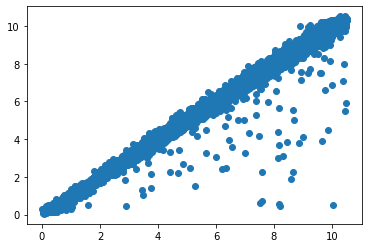

In [14]:
plt.scatter(
    p, 
    gbmForP.predict(
        np.stack(
            (peTotal, peMean, peStd, peCu3, peCu4, peTimeMean, peTimeStd, peTimeCu3, peTimeCu4),
            axis=1
        )
    )
)
plt.show()